# Srinidhi Bharadwaj Kalgundi Srinivas
# A59010584
# CSE 276C - Homework 5

## Solutions:

### Note: The 0 of y-axis is at the bottom and that is why the space is flipped vertically.

###  1) Code output for what the configuration space for 0, 45 and 90 degrees look like is attached below.

![Robot Environment](Images/RobotEnvironment.png)

![Configuration Space 0](Images/Config-0.png)

![Configuration Space 45](Images/Config-45.png)

![Configuration Space 90](Images/Config-90.png)

###  2) Illustration for the shortest path is generated below. The length of the shortest path is 1261.39 units.

![Shortest Path](Images/ShortestPath.png)

###  Safest path is calculated using Vornoi graph and the length of the safest path is 1634.14 units.

![Safest Path](Images/SafestPath.png)

###   4) Probabilistic Road Map(PRM) algorithm is implemented for safe path computation with 3 different sample points as below:

- 50 points: It is observed that there is not always (majority of the times) exists a path between the start and the end points. The function to calculate the path loops until a path is found and provides the shortest path. 

- 100 points: As opposed to 50 points, using 100 points will result in a "no path" considerable lesser number of times.

- 500 points: It is almost always guaranteed that a path exists between the start and the end points.

__Computed path lengths:__

    
| Points | Lengths (in units) |
| :- | :- |
| 50  | 1423.33 |
| 100 | 1423.36  |
| 500 | 1394.22 |

__It can be seen from the above table that the shortest path is achieved when the number of sample points is 500. The length of the sortest path is still greater than Dijkstra's shortest path but much smaller than the safest path calculated using Voronoi diagram.__


![PRM path for 50 Samples](Images/PRM-50.png)

![PRM path for 50 Samples in Configuration Space at 0 degrees](Images/PRM-50_CSpace0.png)

![PRM path for 100 Samples](Images/PRM-100.png)

![PRM path for 100 Samples in Configuration Space at 0 degrees](Images/PRM-100_CSpace0.png)

![PRM path for 500 Samples](Images/PRM-500.png)

![PRM path for 500 Samples in Configuration Space at 0 degrees](Images/PRM-500_CSpace0.png)

Note: I took an iterative approach where in I loop within the function until a path is found. There can be other methods that can be employed as well. This is in tandem with the lecture notes as well.


###  5) Rapid Exploring Random Trees(RRT) algorithm is implemented as given in Planning Algorithms by Steven LaValle. Observations are as below:

__Computed path lengths:__

| Points | Lengths (in units) |
| :- | :- |
| 50  | 1681.14 |
| 100 | 1580.29 |
| 500 | 1479.98 |

__As is the case with PRM, the shortest path length decreases as the number of samples in increased.__

![RRT path for 50 Samples](Images/RRT-50.png)

![RRT path for 50 Samples in Configuration Space at 0 degrees](Images/RRT-50_CSpace0.png)

![RRT path for 100 Samples](Images/RRT-100.png)

![RRT path for 100 Samples in Configuration Space at 0 degrees](Images/RRT-100_CSpace0.png)

![RRT path for 500 Samples](Images/RRT-500.png)

![RRT path for 500 Samples in Configuration Space at 0 degrees](Images/RRT-500_CSpace0.png)


# Comparsion between PRM and RRT in terms of performance:

__Performance comparision is based on the amount of time taken in seconds to build and compute the shortest path between the start and the end points. It is observed that the PRM takes longer time to build than RRT, i.e., RRT runs faster than PRM. However, the path found by PRM is significantly shorter than the path found by RRT.__

__Below table summarizes the output of the code for performance comparision between PRM and RRT:__

| Points | PRM - Lengths (in units) | RRT - Lengths (in units) |
| :- | :- | :- |
| 50  | 1423.33  |1681.14 |
| 100 | 1423.36  |1580.29 |
| 500 | 1394.22  |1479.98 |

| Points | PRM - Time taken (in seconds) | RRT - Time taken (in seconds) |
| :- | :- | :- |
| 50  | 13.75  | 3.32|
| 100 | 19.55  | 2.21|
| 500 | 43.62  | 1.16|

__Building and running PRM and RRT continuously will result in slightly different values but the same trend is followed where PRM is much closer to exhaustive search than RRT and RRT takes lesser time to build than PRM.__


References: 
https://en.wikipedia.org/wiki/Rapidly-exploring_random_tree


In [13]:
import numpy as np
import networkx as network
from itertools import combinations
from matplotlib import patches
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
from scipy.interpolate import interp1d
from collections import UserList, UserDict
import skgeom as skg
import time
from scipy.spatial import Voronoi

# Helper function for bot creation with center point as the robot center
def create_bot(botsize, angle = 0):
    bot_edge = botsize / 2
    points = np.array([[-bot_edge, -bot_edge],
                       [ bot_edge, -bot_edge],
                       [ bot_edge,  bot_edge],
                       [-bot_edge,  bot_edge]])
    theta = np.deg2rad(angle)
    # Rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    pts = (R @ points.T).T
    return skg.Polygon(pts)

# Returns the number of poitns in the polygon
def polygonPoints(poly):
    points = []
    for vertex in list(poly.vertices):
        pt = []
        pt.append(vertex.x())
        pt.append(vertex.y())
        points.append(pt)
    return np.array(points)

# Helper method to create configuration space
def create_config_space(space, robot):
    configSpace = []
    pts = polygonPoints(robot)
    R = np.array([[-1, 0],
                  [0, -1]])
    robotPoints = (R @ pts.T).T
    for s in space:
        wall = polygonPoints(s)
        v = []
        for v1 in robotPoints:
            for v2 in wall:
                tmp = v1 + v2
                v.append(skg.Point2(tmp[0],tmp[1]))        
        hullPts = skg.convex_hull.graham_andrew(v)
        configSpace.append(skg.Polygon(hullPts))
    return configSpace

#Wrapper function to convert map to list
#https://stackoverflow.com/questions/18939596/python-difference-between-filterfunction-sequence-and-mapfunction-sequence
def mapl(inp, *seq):
    return list(map(inp, *seq))

# Given 2 input vectors v1 and v2, return sample edges for the vectors
def sample_edge(v1, v2, samples, theta=None):
        sample_points = []
        x1, y1 = v1
        x2, y2 = v2
        #Check whether the 2 points are close to one another
        if np.isclose((x2 - x1), 0):
            x = [x1] * samples #Create as many x1 points as there are samples
            y = np.arange(y1, y2, (y2 - y1) / samples)
        else:
            m = (y2 - y1) / (x2 - x1)
            c = y1 - (m * x1)
            x = np.arange(x1, x2, (x2 - x1) / samples)
            y = m * x + c
        thetas = [theta] * samples
        val = val
        for p in zip(x, y, thetas):
            sample_points.append(p)
        return sample_points


# Wrapper function that rotates the robot and return the end configuration
def adjacent_square(x, y, theta):
    #Mapping between angle of the robot and points
    Angles = {0: (1, 0), 5: (11, 1), 10: (6, 1), 15: (4, 1), 20: (3, 1), 25: (2, 1), 30: (9, 5), 35: (3, 2), 40: (6, 5), 45: (1, 1),
             50: (5, 6), 55: (2, 3), 60: (5, 9), 65: (1, 2), 70: (1, 3), 75: (1, 4), 80: (1, 6), 85: (1, 11), 90: (0, 1)}
    ax, ay = Angles[theta]
    return x + ax, y + ay

def plot(start, target, path, pathLabel='Shortest Path'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='red')
    ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='green')
    ax.plot(path[:, 0], path[:, 1], path[:, 2], c='black', label=pathLabel)
    plt.legend()
    plt.show()

In [14]:
# Modified version of https://stackoverflow.com/questions/34190946/forming-a-polygon-with-classes
class Shape(object):
    # Constructor that takes in vertex as input, used in created the configuration space
    def __init__(self, vertices):
        self.vertices = np.array(vertices)
        self.vertex_sort()
        self.hull = None
    
    # Helper function to check of the given point in inside the polygon. 
    # Utilizes Delaunay Tessellation method
    def contains(self, point):
        if self.hull is None:
            self.hull = Delaunay(self.vertices)
        return self.hull.find_simplex(point) >= 0

    # Weapper function used for building Voronoi diagram
    def get_dense_edges(self, samples, theta=None):
        self.vertex_sort()
        edge_points = []
        # Loop through all the vertices of the given polygon and extract the edge points
        for i in range(len(self.vertices) - 1):
            v1, v2 = self.vertices[i], self.vertices[i + 1]
            edge_points.extend(sample_edge(v1, v2, samples, theta))
            
        #Pick the last and the first vertex and extend them   
        v1, v2 = self.vertices[-1], self.vertices[0]
        edge_points.extend(sample_edge(v1, v2, samples, theta)) 
        
        return edge_points

    # Sort the angles based on the centroid
    def vertex_sort(self):
        centroid = np.mean(self.vertices, axis=0)
        centered_vertices = self.vertices - centroid
        # Calculate angles for the centered vertices
        angles = [np.arctan2(v[1], v[0]) for v in centered_vertices]

        temp = list(sorted(enumerate(self.vertices), key=lambda t: angles[t[0]]))
        sorted_vertices = np.array(mapl(lambda tupl: tupl[1], temp))
        self.vertices = sorted_vertices

    # Rotate vertices using 2D rotation matrix
    def vertex_rotate(self, rot):
        centroid = np.mean(self.vertices, axis=0)
        centered_vertices = self.vertices - centroid
        angle = np.deg2rad(rot)
        
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        vertices = (R @ centered_vertices.T).T
        vertices += centroid
        return vertices

    def to_patches_polygon(self):
        self.vertex_sort()
        return patches.Polygon(self.vertices)


# Class to constuct a rectangle (Wrapper for easier understanding)
# Takes in points, width and height as inputs and uses polygon class to create polygon - In this case, a rectangle
class Room(Shape):
    def __init__(self, width, height, point):
        self.width = width
        self.height = height
        self.point = point
        vertices = []
        for x in (0, width):
            for y in (0, height):
                vertices.append([point[0] + x, point[1] + y])
        Shape.__init__(vertices)

# Class to construct a rectangle while considering the rotatioin of the robot
class RobotInRoom(Room):
    def __init__(self, width, height, point, rot=0):
        lxy = [-point[0], -point[1]]
        Room.__init__(width, height, point)
        theta = np.deg2rad(rot)
        # 2D rotation matrix
        R = np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])
        # Roate the vertices
        self.vertices = (R @ self.vertices.T).T

# Wrapper class to create the environment for the robot
class Robot_Env(UserList):
    def __init__(self, Shapes=None):
        Shapes = []
        self.data = Shapes 
        
    def inside_wall(self, point):
        #Loop through all the points in the environment
        for obstacle in self.data:
            if point in obstacle:
                return True
        return False


# Helper function to create graphs using networkkx library and add edges based on the angle
def graph_create(cspace):
    #Create a graph using networkkx library
    graph = network.Graph()
    #Loop through all the points and all the angles
    for x in range(1, 801):
        for y in range(1, 301):
            #Looping through angles
            for angle in range(0, 91, 5):
                if angle != 90:
                    add_edge(graph, (x, y, angle), (x, y, angle + 5), cspace, 0)
                next_block(x, y, angle, graph, cspace)
                
    return graph

# Check if an edge needs to be added and add it
def add_edge(graph, point1, point2, cspace, w=None):
    x1, y1, theta1 = point1
    x2, y2, theta2 = point2
    if cspace[theta1].inside_wall((x1, y1)) or cspace[theta2].inside_wall((x2, y2)):
        return False
    if w is None:
        # Calculate the Eucledian distance
        w = np.linalg.norm((x1 - x2, y1 - y2))
    graph.add_edge(point1, point2, weight=w)
    return True

# Method to check the next block for the robot to move in
def next_block(x, y, theta, graph, cspace):
    env = cspace[theta]
    x2, y2 = adjacent_square(x, y, theta)
    if doesIntersect((x, y, theta), (x2, y2, theta), env):
        add_edge(graph, (x, y, theta), (x2, y2, theta), cspace)
    
# Helper method to check if edges intersect given an environment
def doesIntersect(p1, p2, env):
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    num_samples = int(np.linalg.norm((x1 - x2, y1 - y2)))
    if num_samples == 0: 
        return True
    samples = sample_edge((x1, y1), (x2, y2), num_samples)
    is_intersect = any(map(env.inside_wall, samples))
    return ~is_intersect

# Wrapper to handles all graph data structure related operations
# https://stackoverflow.com/questions/19472530/representing-graphs-data-structure-in-python
class Graph(UserDict):
    def __init__(self, graph=None):
        if graph != None:
            self.data = graph
        else:
            self.data = {}
        # Vertex set
        self.vset = set()
    
    # Function that returns all the certices in the graph
    def ret_vertices(self):
        if not self.vset:
            self.vset = set()
            for key in self.data:
                self.vset.add(key)
                for inner_key in self.data[key]:
                    self.vset.add(inner_key)
        return self.vset
    
    # Method to add edges in the graph
    def add_edge(self, p1, p2, w):
        t1, t2 = tuple(p1), tuple(p2)
        self.data[t1, t2] = w
    
    # Method to add vertices in the configuration space given the angles
    def populate_vset(self, cspace, angles):
        for i, plane in enumerate(cspace):
            angle = angles[i]
            for vertex in plane:
                self.vset.add((vertex[0], vertex[1], angle))

In [15]:
# Added import methods again to keep it independent of the helper methods

In [16]:
import numpy as np
from itertools import chain
import matplotlib
import pickle
import heapq as hq
import networkx as network
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
import time
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 6)

In [17]:
# Helper method to return random points
def random_point(xmin=0, xmax=801, ymin=0, ymax=301, tint=5):
    rx = np.random.randint(xmin, xmax)
    ry = np.random.randint(ymin, ymax)
    rtheta = np.random.choice(list(range(0, 91, tint)))
    return (rx, ry, rtheta)

# Plot the environment
# Inspiration: https://stackoverflow.com/questions/26935701/ploting-filled-polygons-in-python
def plot_space(env, path=None, scatter_points=None):
    fig, ax = plt.subplots()
    patches = mapl(lambda poly: poly.to_patches_polygon(), env)
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.9)
    major_ticks_x = np.arange(0, 801, 25)
    major_ticks_y = np.arange(0, 301, 25)
    ax.add_collection(p)
    ax.set_xticks(major_ticks_x)
    ax.set_yticks(major_ticks_y)    
    ax.xaxis.tick_top()
    
    if path is not None:
        plt.plot(path[:, 0], path[:, 1], c='red', label='Shortest Path')
    if scatter_points is not None:
        plt.scatter(scatter_points[:, 0], scatter_points[:, 1], label='Nodes')
    
    if path is not None or scatter_points is not None:
        plt.legend()
    plt.show()

In [18]:
#Defining parameters 
# Parameters are points in 2D space, length, height
wall_list = []
wall1 = Room(800, 1, [0, 0])
wall2 = Room(800, 1, [0, 299])
wall3 = Room(1, 300, [0, 0])
wall4 = Room( 1, 300, [799, 0])
wall5 = Room( 1, 200, [200, 0])
wall6 = Room( 200, 1, [100, 199])
wall7 = Room( 1, 200, [400, 100],)
wall8 = Room( 1, 200, [600, 0],)
wall9 = Room( 200, 1, [500, 199],)
wall_list.append(wall1)
wall_list.append(wall2)
wall_list.append(wall3)
wall_list.append(wall4)
wall_list.append(wall5)
wall_list.append(wall6)
wall_list.append(wall7)
wall_list.append(wall8)
wall_list.append(wall9)
# Create an environment for the robot
room = Robot_Env(wall_list)

In [ ]:
robot_size = 50
robot_size_side = robot_size / 2
cspace_angles = [0, 45, 90]

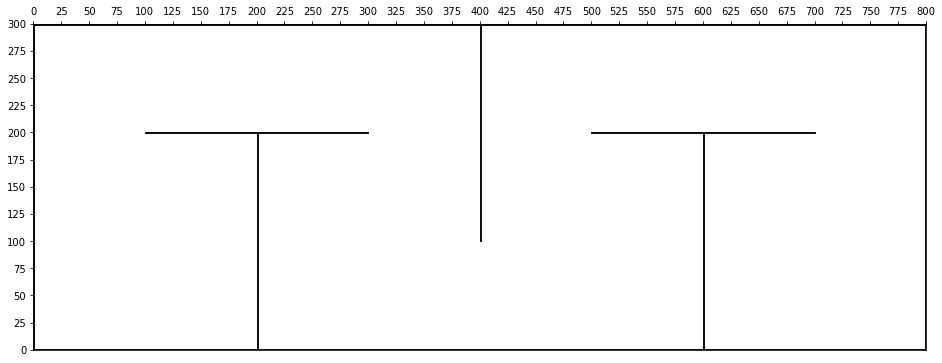

In [73]:
plot_space(room)

# Problem 1:  Config space for robot at orientation - 0

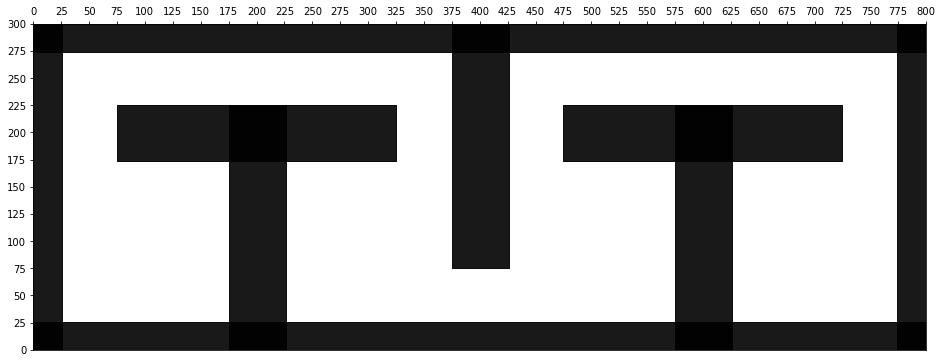

In [74]:
robot = RobotInRoom(robot_size_side, robot_size_side, robot_size, robot_size, cspace_angles[0])
config_space0 = Environment(mapl(lambda poly: robot + poly, room))
plot_space(config_space0)

# Problem 1:  Config space for robot at orientation - 45

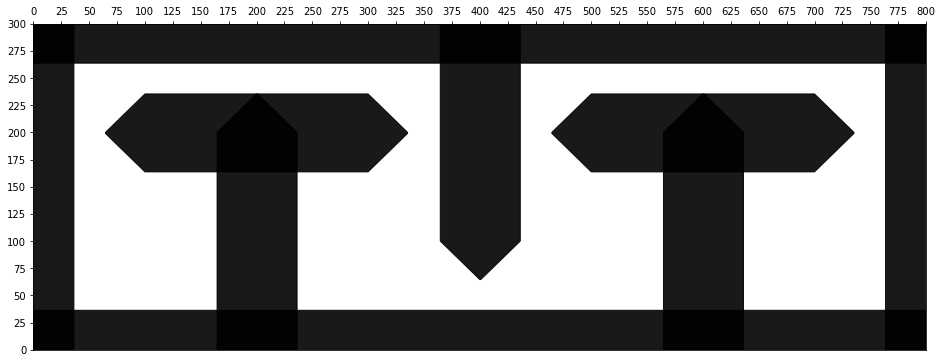

In [75]:
robot = RobotInRoom(robot_size_side, robot_size_side, robot_size, robot_size, cspace_angles[1])
config_space45 = Environment(mapl(lambda poly: robot + poly, room))
plot_space(config_space45)

# Problem 1:  Config space for robot orientation - 90

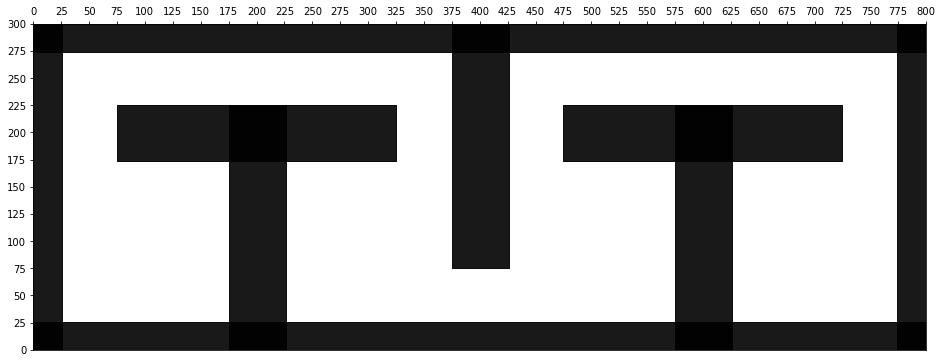

In [76]:
robot = RobotInRoom([robot_size_side, robot_size_side], robot_size, robot_size, cspace_angles[2])
config_space90 = Environment(mapl(lambda poly: robot + poly, room))
plot_space(config_space90)

In [11]:
#Configuration space dictionary with 5 degree angular resolution
configuration_space_dict = {}
for angle in range(0, 91, 5): #91 is used instead of 90 to circumvent the python range caveat
    robot = RobotInRoom([robot_size_side, robot_size_side], robot_size, robot_size, theta)
    cspace = Robot_Env(mapl(lambda poly: robot + poly, room))
    configuration_space_dict[angle] = cspace

In [26]:
# Uncomment the below 3 lines to generate graphs
# Pickle file is created for the graph, stored and read

# full_graph = graph_create(cspace)
# with open('saved_graph.pkl', 'wb') as gfile:
#     pickle.dump(full_graph, gfile)

20
0
0
40
56239
43265
60
228066
134920
80
388185
217045
100
518817
285014
120
642147
350039
140
764574
414848
160
886500
479174
180
945477
508263
200
970057
521863
220
994637
535463
240
1051556
574028
260
1173976
640196
280
1296412
705031
300
1419868
770521
320
1550998
840575
340
1712317
927498
360
1883524
1016112
380
1968911
1056888
400
1997866
1072497
420
2027191
1088778
440
2110756
1143586
460
2282583
1234588
480
2442702
1316713
500
2573334
1384682
520
2696664
1449707
540
2819091
1514516
560
2941017
1578842
580
2999994
1607931
600
3024574
1621531
620
3049154
1635131
640
3106073
1673696
660
3228493
1739864
680
3350929
1804699
700
3474385
1870189
720
3605515
1940243
740
3766834
2027166
760
3937113
2114852
780
3988985
2137547
800
3988985
2137547


In [12]:
# saved_graph.pkl is created using the above cell, saved and reused and it takes too long to build the graph
with open('saved_graph.pkl', 'rb') as graph:
    full_graph = pickle.load(graph)

In [1]:
def plot(start, target, path, pathLabel='Shortest Path'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='red')
    ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='green')
    ax.plot(path[:, 0], path[:, 1], path[:, 2], c='black', label=pathLabel)
    plt.legend()
    plt.show()

# 2. Shortest Path between (50, 50) and (750, 50)

Length of the shortest path is 1261.39


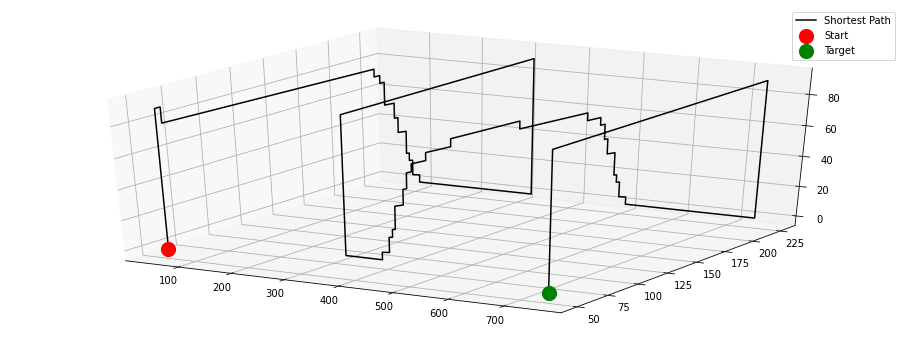

In [15]:
start = (50, 50, 0)
target = (750, 50, 0)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(full_graph, start, target)
shortest_path = np.array(shortest_path)
print('Length of the shortest path is {0}'.format(round(length, 2)))
plot(start, target, shortest_path)


# 3. Compute the safest path from start to finish (hint: medial axis transform/Voronoi). Illustrate the path and provide its length.

In [20]:
# Helper function to get neighbors in a voronoi cell
# Credits: https://stackoverflow.com/questions/4953017/finding-near-neighbors
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query_ball_point.html
# https://www.cs.umd.edu/~mount/Papers/dist.pdf
def get_voronoi_neighbors(v, kdt, min_n=4, max_n=6):
    u = 0.5
    l = 0
    while True:
        ball_size = (u + l) / 2
        n_idxs = kdt.query_ball_point(v, ball_size)
        if len(n_idxs) < min_n:
            l = ball_size
            u *= 2
        elif len(n_idxs) > max_n:
            u = ball_size
            l /= 2
        else:
            break
    return n_idxs

# Helper function to create voronoi graph
# Considered help from: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.voronoi.voronoi_cells.html
def create_voronoi_cell(start, target, verts):
    kdt = cKDTree(verts)
    graph = network.Graph()
    
    distance, idx = kdt.query(start)
    start_point = kdt.data[idx]
    distance, idx = kdt.query(target)
    end_point = kdt.data[idx]
    
    graph.add_edge(tuple(start), tuple(start_point), weight=d)    
    graph.add_edge(tuple(goal), tuple(end_point), weight=d)
    for vertex in kdt.data:
        indices = get_voronoi_neighbors(vertex, kdt)
        for i in indices:
            new_vertex = kdt.data[i]
            diff = np.linalg.norm(vertex - new_vertex)
            graph.add_edge(tuple(vertex), tuple(new_vertex), weight=diff)
    return graph

In [17]:
# Voronoi helper functions
side = 50 * np.sqrt(2) # Diagonal distance
center = side / 2
robot = RobotInRoom([center, center], side, side, 0)
voronoi_env = Robot_Env(mapl(lambda poly: robot + poly, env))
points = []
for polygon in voronoi_env:
    points.extend(polygon.get_dense_edges(200))
voronoi_points = Voronoi(points)

vertices = []
for vertex in voronoi_points.vertices:
    x, y = vertex
    # Check if the vertex is within the given boundary (rectangle)
    if (x >= 0 and x < 801 and y >=0 and y < 301):
        # Verify that the given set of point is not in any obstacle
        if voronoi_env.inside_wall((x, y)) == False:
            vertices.append((x, y))
vertices = np.array(vertices)

# Problem 3: Safest path using Voronoi

In [25]:
start = (50, 50)
target = (750, 50)
voronoi_cell = create_voronoi_cell(start, target, vertices)
length, safest_path = nx.algorithms.bidirectional_dijkstra(voronoi_cell, start, target)
safest_path = np.array(safest_path)
print('Length of the safest path is {0}'.format(round(length,2)))

Length of the safest path is 1634.14


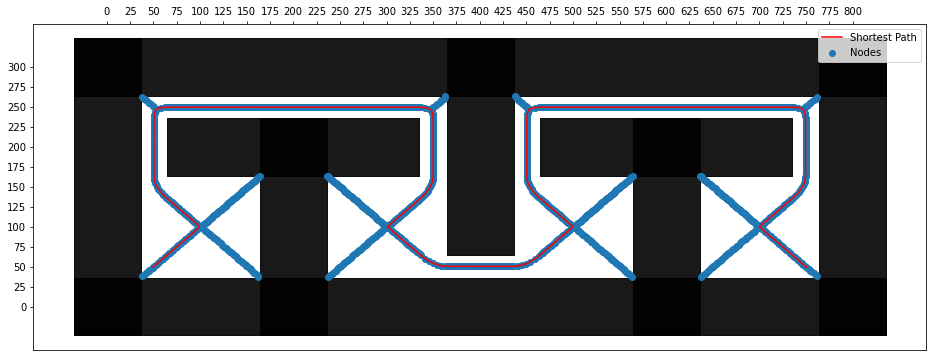

In [83]:
plot_space(voronoi_cell, safest_path, vertices)

# 4. Use probabilistic roadmaps (PRM) to compute a path between startand end-points with 50, 100 and 500 sample points. What is the difference in path length? Illustrate each computed path

In [68]:
# Helper function to build probabilistic road map
def probabilistic_roadmap(start, target, cspace, samples):
    
    graph = network.Graph() 
    # Add start and target nodes to the graph
    graph.add_node(start)
    graph.add_node(target)
    samples_added = 0    
    # Add sample points
    while samples_added < samples:
        graph_array = np.array(graph.nodes)
        # Sample a random point in the environment
        point = random_point()
        # Build a tree
        kdt = cKDTree(graph_array[:, :2])
        distance, idx = kdt.query([point[0], point[1]], k=min(15, graph_array.shape[0]))
        neighbors = graph_array[i]
        isConnected = False
        for neighbor in neighbors:
            # Check if the neighboring edges intersect
            if doesIntersect([neighbor[0], neighbor[1]], [point[0], point[1]], cspace[neighbor[2]]):
                # Check if the point is on the edge itself
                if neighbor[2] != point[2]:
                    connection = add_edge(graph, point, (point[0], point[1], neighbor[2]), cspace)
                    if connection == False:
                        continue
                    added = add_edge(graph, (point[0], point[1], neighbor[2]), tuple(neighbor), cspace)
                    isConnected |= added
        # Consider the added point only if it can be connected to the neighbor
        if isConnected:
            samples_added += 1
        isConnected = False
    return graph       

# Helper function for 50, 100 and 500 sample points

In [70]:
def prm(cspace, num_samples):
    start = (50, 50, 0)
    target = (750, 50, 0)
    time_start = time.time()
    prm_graph = probabilistic_roadmap(start, target, cspace, num_samples)
    time_end = time.time()
    print('Time taken for building PRM for {0} sample points is {1} seconds'.format(num_samples, round(time_end-time_start,4)))
    
    # Obtain the number of connected components in the graph
    num_components = network.components.number_connected_components(prm_graph)
    
    # Adding this loop to ensure I get a sampling that ensures a path from start to end points
    # Of the number of times I have run it, it never caused infinite loop
    while num_components > 1:
        start = (50, 50, 0)
        target = (750, 50, 0)
        prm_graph = probabilistic_roadmap(start, target, cspace, n_sample_points)
        num_components = network.components.number_connected_components(prm_graph)  
        
    length, shortest_path = network.algorithms.bidirectional_dijkstra(prm_graph, start, target)
    shortest_path = np.array(shortest_path)
    print('Length of the shortest path is {0}'.format(round(length,2)))
    
    plot(start, target, shortest_path)
    return (shortest_path, np.array(prm_graph.nodes))

# Problem 4: 50 Sample Points

Time taken for building PRM for 50 sample points is 13.7493 seconds
Length of the shortest path is 1423.33


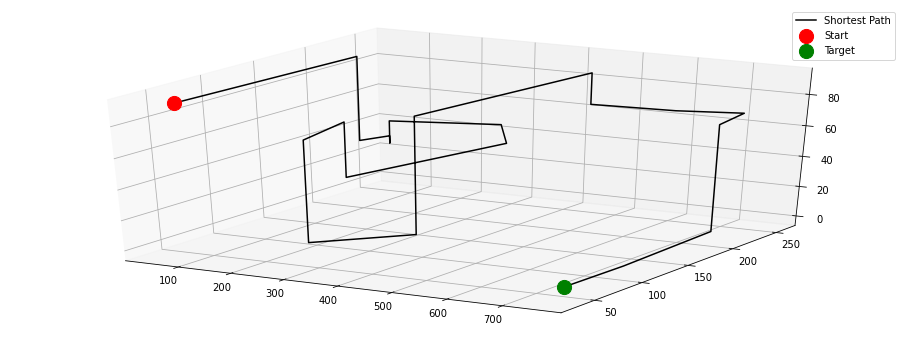

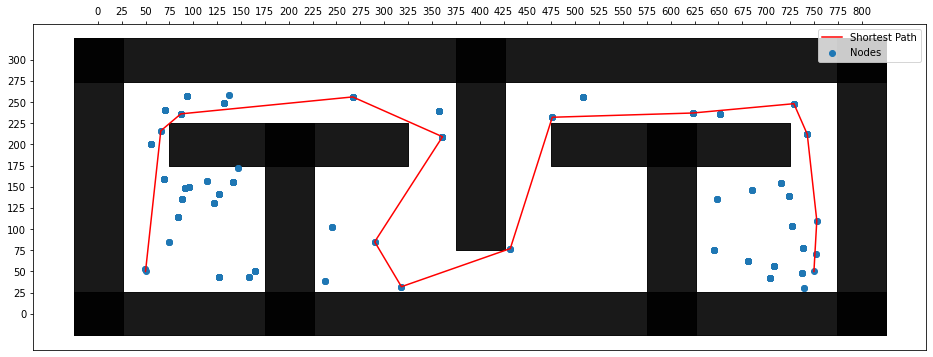

In [93]:
# Compute the shortest path and the connected nodes for configuration space of 0 (Robot at 0 degrees)
shortest_path_50, nodes_50 = prm(configuration_space_dict[0], 50)
plot_polygons(cspace[0], shortest_path_50, nodes_50)

# Problem 4: 100 Sample Points

Time taken for building PRM for 100 sample points is 19.5526 seconds
Length of the shortest path is 1423.36


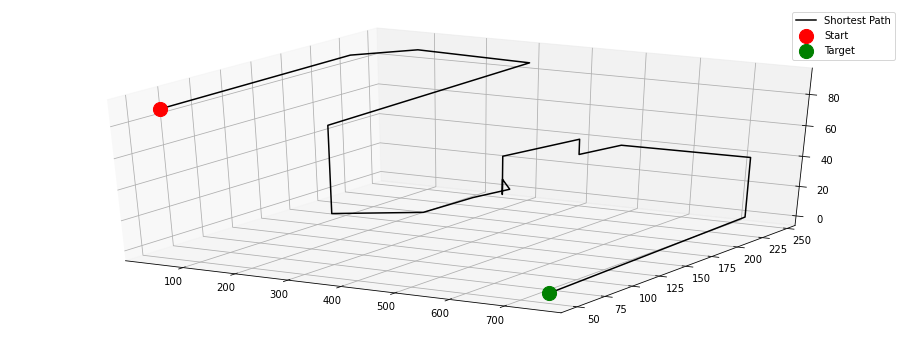

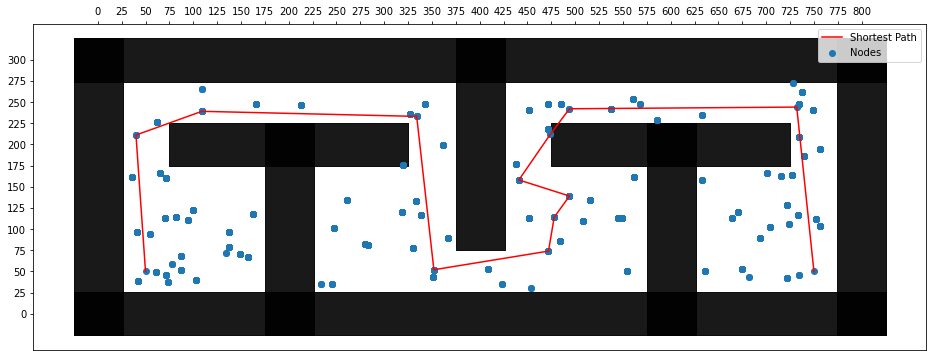

In [94]:
# Compute the shortest path and the connected nodes for configuration space of 0 (Robot at 0 degrees)
shortest_path_100, nodes_100 = prm(configuration_space_dict[0], 100)
plot_polygons(cspace[0], shortest_path_100, nodes_100)

# Problem 4: 500 Sample Points

Time taken for building PRM for 500 sample points is 43.6239 seconds
Length of the shortest path is 1394.22


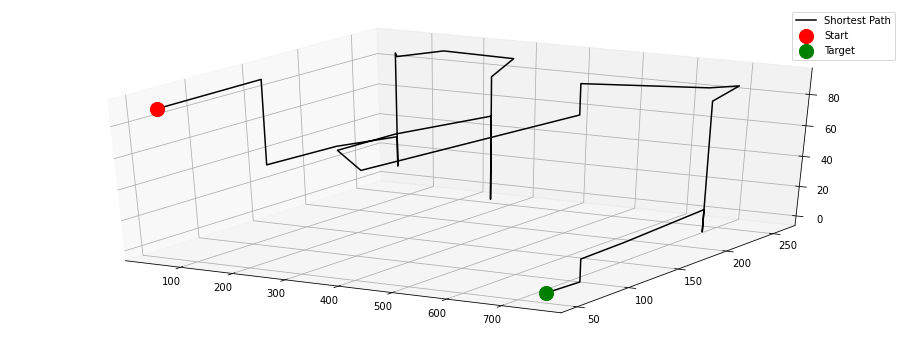

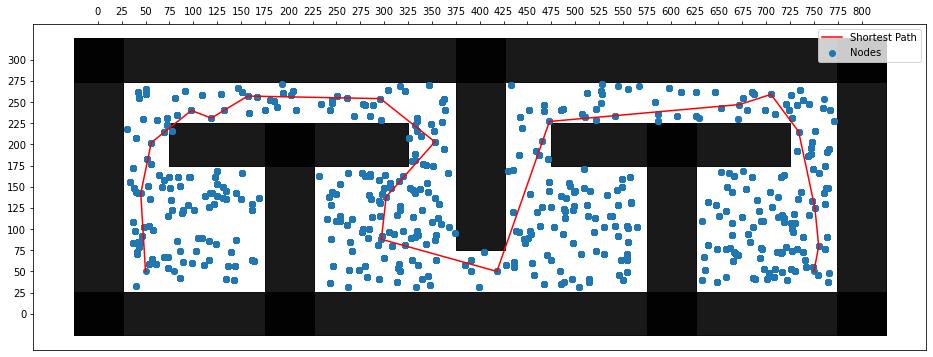

In [97]:
shortest_path_500, nodes_500 = prm(configuration_space_dict[0], 500)
plot_polygons(cspace[0], shortes t_path_500, nodes_500)

# 5. Do the same with Rapid exploring random trees (RRT). What are the main differences in performance between PRM and RRT? Illustrate each path.

In [78]:
# Helper function to plot the RRT graph
def plot_rrt(nodes, shortest_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='green')
    ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='black')
    ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2], label='RRT Nodes', c='blue')
    ax.plot(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2], c='red', label='Shortest Path')
    plt.legend()
    plt.show()

In [75]:
# Helper function to create a chain
# Based on algorithm from wiki
def create_links(qnear, qnew, graph, cspace, link_length):
    end_reached = False
    while end_reached == False:
        qnear_arr = np.array([qnear[0], qnear[1], 0])
        qnew_arr = np.array([qnew[0], qnew[1], 0])
        vnear, vnew = qnear_arr, qnew_arr
        if np.linalg.norm(vnew - vnear) <= link_length:
            qnext = qnew
            end_reached = True
        else:
            # Calculate the unit vector
            unit_vector = (vnew - vnear) / np.linalg.norm(vnew - vnear)
            qnext = vnear + (link_length * unit_vector)
            qnext[2] = qnear[2]
            qnext = qnext.astype(int)
        # Check if the edges intersect and if it does not
        if doesIntersect(qnear, qnext, cspace[qnear[2]]):
            added = add_edge(graph, tuple(qnear), tuple(qnext), cspace)
            if added == False:
                break
        else:
            break
        qnear = qnext
        
# Helper function to find the closest point
def closeest(point, graph):
    x, y, z = point
    nearest = min(graph.nodes, key=lambda point: np.linalg.norm((x - point[0], y - point[1])))
    return nearest
        
# Helper method to create an RRT
# Algorithm source: https://en.wikipedia.org/wiki/Rapidly-exploring_random_tree
def create_rrt(start, target, cspace, link_length):
    graph = network.Graph()
    graph.add_node(start)
    for i in range(10000):
        if np.random.random() < 0.01:
            qnew = target
        else:
            qnew = random_point()
            # Check if the new point is in an obstacle (kind of like getting stuck inside a wall)
            if cspace[qnew[2]].inside_wall((qnew[0], qnew[1])):
                continue
        qnear = closeest(qnew, graph)
        #Link the points in the configuration space
        create_links(qnear, qnew, graph, cspace, link_length)
        if target in graph:
            break
    return graph

# Problem 5: 50 Points

In [62]:
start = (50, 50, 0)
target = (750, 50, 0)
begin = time.time()
rrt_graph = make_rrt(start, target, cspace, 5)
end = time.time()
rrt_nodes = np.array(rrt_graph.nodes)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(rrt_graph, start, target)
shortest_path = np.array(shortest_path)
print('Computing RRT took {0} seconds'.format(round(end - begin,3)))
print(f'Length of shortest path is {round(length,2)}.')

Computing RRT took 3.32 seconds
Length of shortest path is 1681.14.


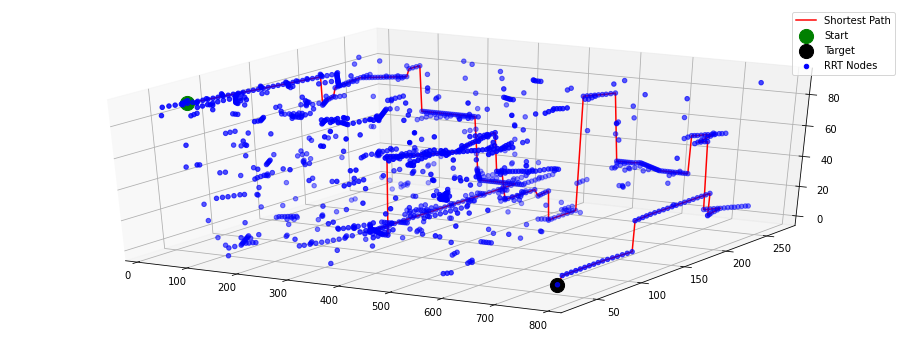

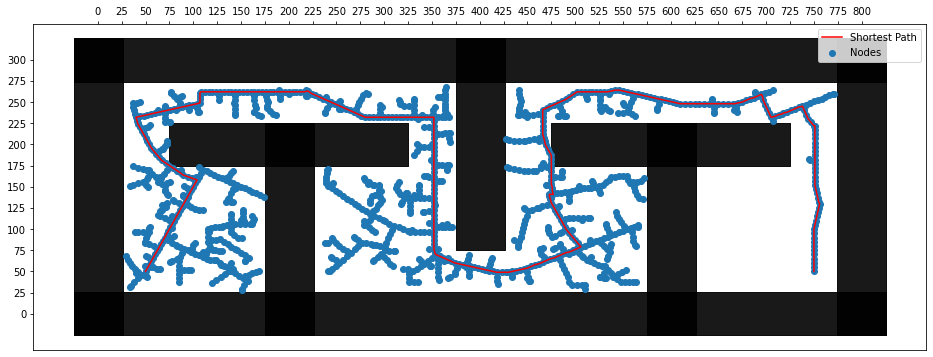

In [86]:
plot_rrt(rrt_nodes, shortest_path)
plot_space(configuration_space_dict[0], shortest_path, rrt_nodes)

In [57]:
rrt_nodes.shape

(996, 3)

# Problem 5: 100 points

In [59]:
start = (50, 50, 0)
target = (750, 50, 0)
begin = time.time()
rrt_graph = make_rrt(start, target, cspace, 10)
end = time.time()
rrt_nodes = np.array(rrt_graph.nodes)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(rrt_graph, start, target)
shortest_path = np.array(shortest_path)
print('Computing RRT took {0} seconds'.format(round(end - begin,3)))
print(f'Length of shortest path is {round(length,2)}.')

Computing RRT took 2.213 seconds
Length of shortest path is 1580.29.


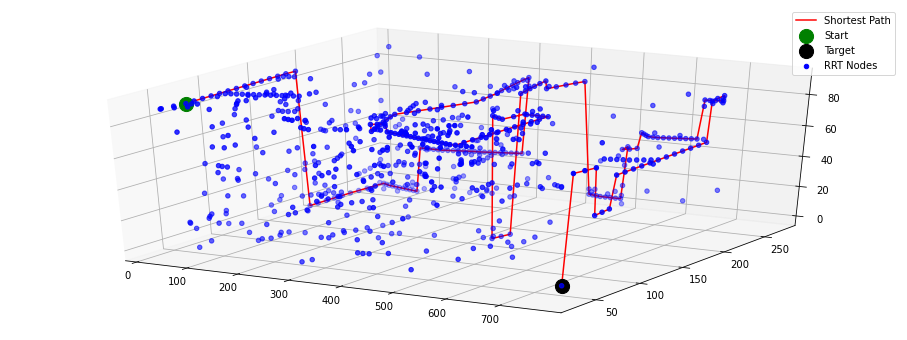

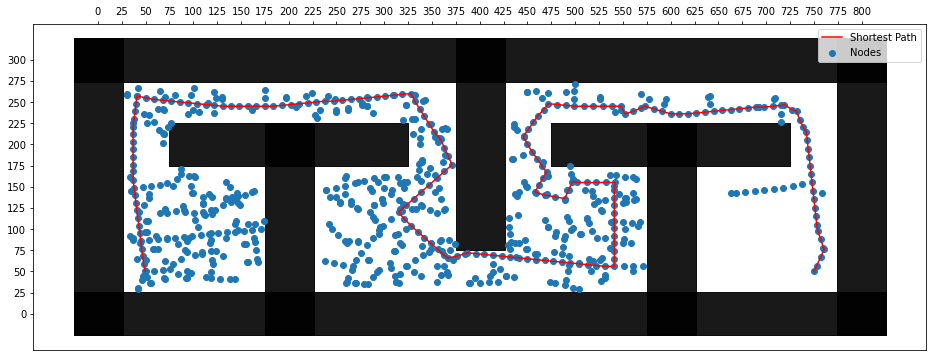

In [88]:
plot_rrt(rrt_nodes, shortest_path)
plot_space(configuration_space_dict[0], shortest_path, rrt_nodes)

# Problem 5: 500 points

In [64]:
start = (50, 50, 0)
target = (750, 50, 0)
begin = time.time()
rrt_graph = make_rrt(start, target, cspace, 50)
end = time.time()
rrt_nodes = np.array(rrt_graph.nodes)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(rrt_graph, start, target)
shortest_path = np.array(shortest_path)
print('Computing RRT took {0} seconds'.format(round(end - begin,3)))
print(f'Length of shortest path is {round(length,2)}.')

Computing RRT took 1.163 seconds
Length of shortest path is 1479.98.


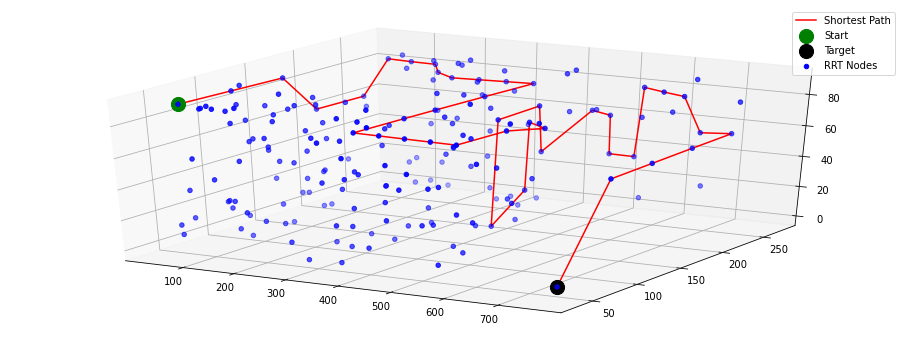

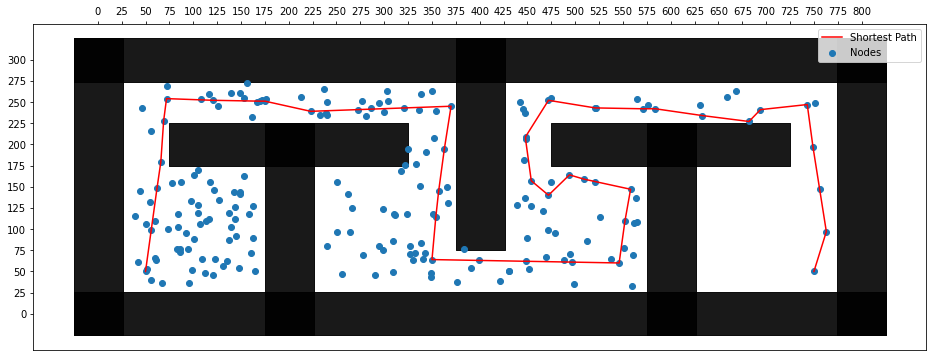

In [90]:
plot_rrt(rrt_nodes, shortest_path)
plot_space(configuration_space_dict[0], shortest_path, rrt_nodes)